In [16]:
#%matplotlib widget
%matplotlib inline

import os
# THIS CAN GIVE RISE TO ERRORS
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'

import torch
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot, ion, show, imshow, draw, pause
import pandas as pd
import math
import time
import os
import gc
import numpy as np
from tqdm import tqdm
import torch.nn.functional as F

#from prettytable import PrettyTable

class LBPSaccadeDataset(Dataset):
    def __init__(self, images, eye_movements, transform=None):
        """
        Args:
            images (list of 2D arrays): List of images.
            eye_movements (list of tuples): List of tuples (num1, num2) for each sample.
            transform (callable, optional): Optional transform to be applied on the sample.
        """
        self.images = images  # List of image paths
        self.eye_movements = eye_movements  # List of tuples containing (num1, num2, output_image_path)
        self.transform = transform  # Optional transformations to apply to images

    def __len__(self):
        return len(self.eye_movements)-1  # Total number of samples

    def __getitem__(self, idx):
        # Load the input image
        #input_image = Image.open(self.image_paths[idx]).convert("RGB")
        
        input_image = self.images[idx]
        # Load the two numbers (num1, num2) associated with this image
        num1, num2 = self.eye_movements[idx]

        # Load the output image (the target image)
        output_image = self.images[idx+1]

        # Apply any transformations to the images (optional)
        if self.transform:
            input_image_pil = transforms.ToPILImage()(input_image.squeeze(0))
            input_image = self.transform(input_image_pil)
            output_image_pil = transforms.ToPILImage()(output_image.squeeze(0))
            output_image = self.transform(output_image_pil)
        
        # Convert numbers to a tensor (optional)
        eye_movement = torch.tensor([[self.eye_movements[idx,0], self.eye_movements[idx,1]]], dtype=torch.float32)

        # Return a dictionary with the data
        return {
            'image0': input_image,  # The input image
            'mov': eye_movement,    # The coordinates as a tensor
            'image1': output_image # The output image (target)
        }


    @staticmethod
    def plot_samples(dataset, num_samples = 5):
        plt.figure(figsize=(20, 5))

        for i in range(num_samples):
            sample = dataset[i]
            plt.subplot(2, num_samples,i+1)
            plt.imshow(sample['image0'].permute(1,2,0))
            plt.title(sample['mov'])
            plt.subplot(2, num_samples,i+num_samples+1)
            plt.imshow(sample['image1'].permute(1,2,0))

        plt.show()



class SaccadePredictor(nn.Module):
    def __init__(self):
        super(SaccadePredictor, self).__init__()

        self.simple_encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # [1, 120, 160] -> [16, 120, 160]            
        )

        # Encoder with proper downsampling
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),  # [1, 120, 160] -> [16, 120, 160]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # [16, 120, 160] -> [16, 60, 80]
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),  # [16, 60, 80] -> [32, 60, 80]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # [32, 60, 80] -> [32, 30, 40]
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),  # [32, 30, 40] -> [64, 30, 40]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # [64, 30, 40] -> [64, 15, 20]
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),  # [64, 15, 20] -> [128, 15, 20]
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),  # [128, 15, 20] -> [128, 7, 10]
            
            # Adaptive Pooling to reduce the feature map size
            nn.AdaptiveAvgPool2d((4, 5))  # Fixed output size: [128, 4, 5]
        )

        # Fully connected layer after flattening the encoder output
        self.fc = nn.Linear(2562, 81920)



    def forward(self, x, saccade_info):
        #print(f"x: {x.shape}")
        #print(f"saccade_info: {saccade_info.shape}")    
        
        # Encoder forward pass
        encoded = self.encoder(x)  # Output size: [1, 128, 4, 5]
        #print("Encoded shape:", encoded.shape)

        # Flatten the encoded tensor
        encoded_flattened = encoded.view(encoded.size(0), -1)  # Size: [1, 128*4*5]
        print("Flattened encoded shape:", encoded_flattened.shape)

        # Flatten the saccade tensor
        saccade_info_flattened = saccade_info.view(saccade_info.size(0), -1)  # [10, 2]
        print("Saccade info flattened:", saccade_info_flattened.shape)
        
        # Combine with saccade features
        combined_features = torch.cat((encoded_flattened, saccade_info_flattened), dim=1)  # Size: [1, 128*4*5 + 2]
        print("Combined features1:", combined_features.shape)

        # Pass through the fully connected layer
        combined_features = self.fc(combined_features)
        #print(f"Combined_features2: {combined_features.shape}")
        
        # Output the reconstructed image (if you're performing reconstruction)
        # For simplicity, this can be just a placeholder
        reconstructed_image = combined_features.view(combined_features.size(0), 1, 256, 320)  # Example shape adjustment
        #print(f"Reconstructed image: {reconstructed_image.size()}")  # Debug line

        # Use functional interpolate to resize to [10, 1, 120, 160]
        resized_image = F.interpolate(reconstructed_image, size=(120, 160), mode='bilinear', align_corners=False)
        #print(f"Resized image: {resized_image.size()}")  # Debug line
        
        return resized_image

       
class UNetWithSaccade(nn.Module):
    def __init__(self):
        super().__init__()

        # Encoder (Downsampling)
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1),  # [1, 120, 160] -> [4, 120, 160]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),  # [4, 120, 160] -> [4, 60, 80]
            nn.Conv2d(4, 8, kernel_size=3, stride=1, padding=1),  # [4, 60, 80] -> [8, 60, 80]
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)  # [8, 60, 80] -> [8, 30, 40]
        )

        # Bottleneck
        self.bottleneck = nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1)  # [8, 30, 40] -> [16, 30, 40]

        # Decoder (Upsampling)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(16, 8, kernel_size=2, stride=2),  # [16, 30, 40] -> [8, 60, 80]
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(8, 4, kernel_size=2, stride=2),  # [8, 60, 80] -> [4, 120, 160]
            nn.ReLU(inplace=True),
            nn.Conv2d(4, 1, kernel_size=1)  # Output layer to return to 1 channel (final output size [10, 1, 120, 160])
        )

        # Fully connected layer to combine saccade information with encoded features
        self.fc = nn.Linear(4 * 30 * 40 + 2, 4 * 30 * 40)  # Flatten saccade info and encoder output

    def forward(self, x, saccade_info):
        #print(f'Input x shape: {x.shape}')  # Print the input shape
        saccade_info = saccade_info.squeeze()
        print(f'Input saccad_info shape: {saccade_info.shape}')  # Print the input shape
        
        
        # Encoding (Downsampling)
        x1 = self.encoder[0:3](x)  # First conv and maxpool
        #print(f'x1 shape after encoder first conv and pool: {x1.shape}')
        
        x2 = self.encoder[3:6](x1)  # Second conv and maxpool
        #print(f'x2 shape after encoder second conv and pool: {x2.shape}')

        # Bottleneck
        x3 = self.bottleneck(x2)
        #print(f'x3 shape after bottleneck: {x3.shape}')

        # Flatten the output of the bottleneck and concatenate with saccade info
        x3_flattened = x3.view(x3.size(0), -1)  # Flatten the feature map
        print(f'x3_flattened shape: {x3_flattened.shape}')

        # Ensure saccade_info has the same batch dimension (shape [batch_size, 2])
        # Unsqueeze saccade_info to have shape [batch_size, 2, 1, 1]
        #saccade_info_unsqueezed = saccade_info.unsqueeze(2).unsqueeze(3)  # [batch_size, 2, 1, 1]
        #print(f'saccade_info_unsqueezed shape: {saccade_info_unsqueezed.shape}')
        
        # Fix: Expand saccade_info across the spatial dimensions of x3 (size [batch_size, 2, 30, 40])
        #saccade_info_expanded = saccade_info_unsqueezed.expand(-1, -1, x3.size(2), x3.size(3))  # [batch_size, 2, 30, 40]
        #print(f'saccade_info_expanded shape: {saccade_info_expanded.shape}')

        # Flatten the expanded saccade_info to match the flattened feature map
        #saccade_info_flattened = saccade_info_expanded.reshape(x3.size(0), -1)  # Flatten to [batch_size, 2 * 30 * 40]
        #print(f'saccade_info_flattened shape: {saccade_info_flattened.shape}')

        

        # Concatenate the flattened saccade info with the flattened feature map from x3
        combined_features = torch.cat((x3_flattened, saccade_info), dim=1)  # [batch_size, 16*30*40 + 2]
        print(f'combined_features shape: {combined_features.shape}')

        # Pass through a fully connected layer to combine saccade info and image features
        combined_features = self.fc(combined_features)
        print(f'combined_features shape after fc: {combined_features.shape}')

        # Reshape to match the decoder's input size
        combined_features = combined_features.view(-1, 16, 30, 40)
        #print(f'combined_features shape after reshape: {combined_features.shape}')

        # Decoding (Upsampling)
        x4 = self.decoder[0:2](combined_features)  # Upsample from [16, 30, 40] to [8, 60, 80]
        #print(f'x4 shape after first decoder layer: {x4.shape}')

        x5 = self.decoder[2:4](x4)  # Upsample from [8, 60, 80] to [4, 120, 160]
        #print(f'x5 shape after second decoder layer: {x5.shape}')

        out = self.decoder[4](x5)  # Final convolution to produce the output of shape [10, 1, 120, 160]
        #print(f'output shape: {out.shape}')

        return out





device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print('matplotlib: {}'.format(matplotlib.__version__))
print(f"cuda available: {torch.cuda.is_available()}")
print(f"device: {device}")
print('Ready!')



matplotlib: 3.5.3
cuda available: True
device: cuda
Ready!


Reading file: ../good_data/EyeMovementsHorizontal.avi
Video size (b/w): torch.Size([853, 1, 720, 1280])
torch.Size([1, 60, 80])
tensor([[4., 0.]])
torch.Size([1, 60, 80])


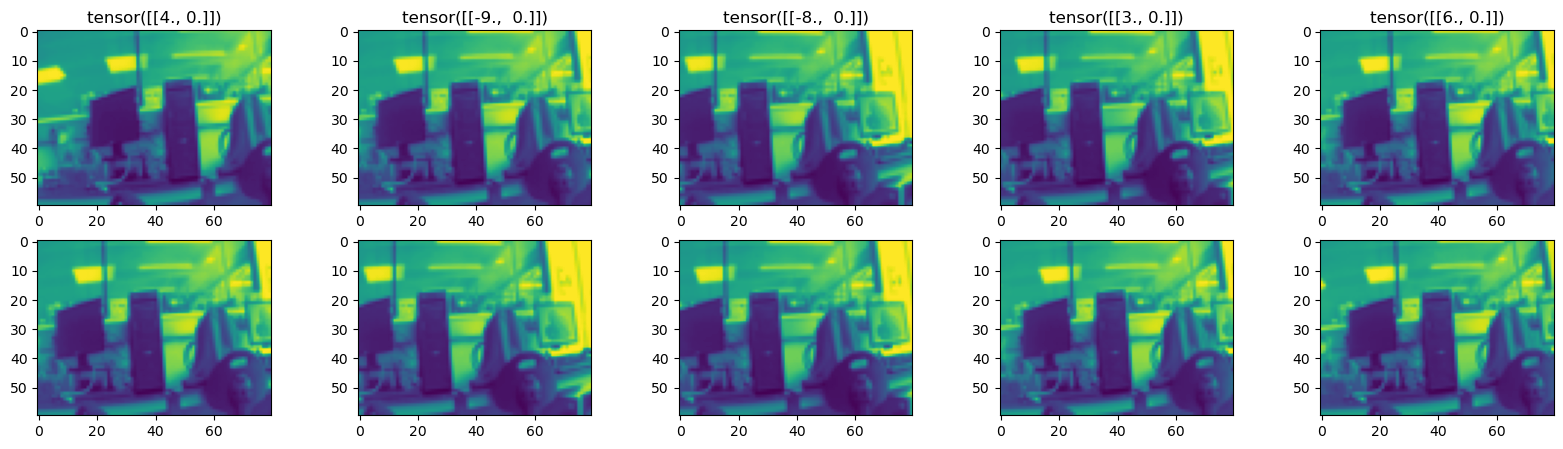

In [4]:
# Data loading
 
# Read video data
filename = "../good_data/EyeMovementsHorizontal.avi"
print(f"Reading file: {filename}")
video = torchvision.io.read_video(filename)[0]
video = video.float()
frames = torch.mean(video,3,True) / 255
frames = frames.permute(0,3,1,2)
#frames = frames[:,:30,:30]
print(f"Video size (b/w): {frames.size()}")

# Read movement data
csvFile = pd.read_csv("../good_data/EyeMovementsHorizontal.csv", header=None)
mov = torch.tensor(csvFile.values)

# Define the transformation for resizing
transform = transforms.Compose([
    transforms.Resize((60, 80)),  # Resize to 240x320 (Height x Width)
    transforms.ToTensor(),  # Convert to tensor
    transforms.Normalize((0.5,), (0.5,))  # Normalize (if needed)
])


dataset = LBPSaccadeDataset(images=frames, eye_movements=mov, transform=transform)

# Accessing a sample
sample = dataset[0]
print(sample['image0'].shape)  # Tensor of input image
print(sample['mov'])            # Tensor of numbers
print(sample['image1'].shape) # Tensor of output image

LBPSaccadeDataset.plot_samples(dataset, 5)


del video, frames

# Convert to sparse encoding
#def gaus2d(x, y, mx=10, my=-10, sx=2, sy=2):
#    return 1. / (2. * np.pi * sx * sy) * np.exp(-((x - mx)**2. / (2. * sx**2.) + (y - my)**2. / (2. * sy**2.)))

#x = np.linspace(-15, 16, num=15)
#y = np.linspace(-15, 16, num=15)
#x, y = np.meshgrid(x, y) # get 2D variables instead of 1D





In [17]:
#os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'


# Clear cuda cache
torch.cuda.empty_cache()


# Create Dataset and DataLoader
dataloader = DataLoader(dataset, batch_size=4, shuffle=True)


# Initialize model, loss function, and optimizer
model = UNetWithSaccade().to('cuda' if torch.cuda.is_available() else 'cpu')
criterion = nn.MSELoss()  # Example: MSE loss for reconstruction tasks
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
epochs = 20
for epoch in range(epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    loop = tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}')  # To display a progress bar
    
    for i, batch in enumerate(loop):
        
        image0 = batch['image0'].to(device)  # Get input image
        saccade_info = batch['mov'].to(device)  # Get saccade info
        image1 = batch['image1'].to(device)  # Get target image
        
        # Zero gradients, perform a backward pass, and update the weights.
        optimizer.zero_grad()

        # Forward pass
        output = model(image0, saccade_info)

        # Compute the loss
        loss = criterion(output, image1)
        
        # Backpropagate the loss
        loss.backward()
        
        # Update weights
        optimizer.step()
        
        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

        torch.cuda.empty_cache()

    
    # Show memory usage
    total_memory = torch.cuda.get_device_properties(0).total_memory
    allocated_memory = torch.cuda.memory_allocated(0)
    reserved_memory = torch.cuda.memory_reserved(0)

    print(f"Total memory: {total_memory / (1024 ** 3):.2f} GB")
    print(f"Allocated memory: {allocated_memory / (1024 ** 3):.2f} GB")
    print(f"Reserved memory: {reserved_memory / (1024 ** 3):.2f} GB")

    # Print average loss for this epoch
    print(f"Epoch {epoch+1}, Loss: {running_loss / len(dataloader)}")

print("Training complete!")

Epoch 1/20:   0%|          | 0/213 [00:00<?, ?it/s]c:\Users\HugoMarques\Anaconda3\envs\PyTorch\lib\site-packages\torch\nn\modules\loss.py:530: UserWarning: Using a target size (torch.Size([4, 1, 60, 80])) that is different to the input size (torch.Size([1, 1, 120, 160])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
Epoch 1/20:   0%|          | 0/213 [00:00<?, ?it/s]

Input saccad_info shape: torch.Size([4, 2])
x3_flattened shape: torch.Size([4, 4800])
combined_features shape: torch.Size([4, 4802])
combined_features shape after fc: torch.Size([4, 4800])


RuntimeError: The size of tensor a (160) must match the size of tensor b (80) at non-singleton dimension 3

In [11]:
sample = dataset[0]


model.to("cpu")

image0 = sample['image0']
mov =  sample['mov']

print("image0 shape: ", image0.shape)
print("mov shape: ", mov.shape)
image0_in = image0.unsqueeze(0)
mov_in = mov.unsqueeze(0)

output = model(image0_in, mov_in)


output_image = output.squeeze(0).detach().numpy()
input_image = image0_in.squeeze(0).detach().numpy()

print(sample['image1'].shape)

plt.subplot(2,1,1)
plt.imshow(output_image.squeeze(0))

plt.subplot(2,1,2)
plt.imshow(sample['image1'].squeeze(0))





image0 shape:  torch.Size([1, 120, 160])
mov shape:  torch.Size([1, 2])


IndexError: Dimension out of range (expected to be in range of [-2, 1], but got 2)